In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets
import IPython
from IPython.display import display, clear_output
import warnings


resolution = 300 #dpi
tick_size = 18
fontlabel_size = 18

figure_width = 377 / 25.4 #conversion to mm is 25.4
figure_height = 233 / 25.4 #conversion to mm is 25.4
figure_size = (figure_width, figure_height)

params = {
    'lines.markersize' : 2,
    'axes.labelsize': fontlabel_size,
    'legend.fontsize': fontlabel_size,
    'xtick.labelsize': tick_size,
    'ytick.labelsize': tick_size,
    'figure.figsize': figure_size,
    'xtick.direction':     'in',     # direction: {in, out, inout}
    'ytick.direction':     'in',     # direction: {in, out, inout}
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.pad':  8,
    'ytick.major.pad':  8,
    'font.family' : 'serif,',
    'ytick.labelsize' : fontlabel_size,
    'xtick.labelsize' : fontlabel_size,
    'axes.linewidth' : 1.2
}
plt.rcParams.update(params)

In [2]:
mfs_range = np.linspace(0,1,1000)

filepath_CRC_data = 'CRC Solution Properties.txt'
df_CRC_data = pd.read_csv(filepath_CRC_data, sep = '\t', comment= '#', encoding='latin-1').drop('Row',axis=1)

#df_CRC_data.fillna('Empty', inplace=True)

CAS_numbers = df_CRC_data.CAS_Reg_No.unique()

grouped_CRC_data = df_CRC_data.groupby('CAS_Reg_No')


In [3]:
#Descriptors of solutes
solutions = ['SubHeader',
             'Solute',
             'Synonym',
             'CAS_Reg_No',
             'Mol_wt',
             'data',
             'MFS_molal',
             'MFS_molar',
             'Density',
             'Refractive_index_n',
             'T_freeze_supression',
             'Viscosity_dynamic']

#Different ways of expressing concentration
conc_measurements = ['Mass_prct',
                    'Mass_fraction',
                    'Molality_m',
                    'Molarity_c']

#Concentrative properties of solution
solution_properties = ['Density',
                       'Refractive_index_n',
                       'T_freeze_supression',
                       'Viscosity_dynamic']

three_lists = [solutions,
               conc_measurements,
               solution_properties]

#turn lists into dicts
solutions = dict.fromkeys(solutions)
conc_measurements = dict.fromkeys(conc_measurements)
solution_properties = dict.fromkeys(solution_properties)

conc_measurements['Mass_prct'] = 'W/W Mass / %'
conc_measurements['Mass_fraction'] = 'Mass Fraction Solute'
conc_measurements['Molality_m'] = 'Molality / mol/kg'
conc_measurements['Molarity_c'] = 'Molarity / mol/L'

solution_properties['Density'] = 'Density / kg/L'
solution_properties['Refractive_index_n'] = 'Refractive Index'
solution_properties['T_freeze_supression'] = '-$\delta$T / K'
solution_properties['Viscosity_dynamic'] =  'Dynamic Viscosity / Pas'



In [4]:
for key in solutions:
    solutions[key] = []
    if key == 'data':
        for number in CAS_numbers:
            solutions[key].append(grouped_CRC_data.get_group(number))
        continue
    if key == 'MFS_molal' or key == 'MFS_molar' or key == 'Density' or key == 'Refractive_index_n' or key == 'T_freeze_supression'or key == 'Viscosity_dynamic':
        solutions[key] = [None] * len(solutions['CAS_Reg_No'])
        continue
    for number in CAS_numbers:
        solutions[key].append(grouped_CRC_data.get_group(number).iloc[0][key])

In [5]:
def GUI():

    solute_dropdown = widgets.Dropdown(options = solutions['Solute'], value = 'Sodium chloride')
    conc_dropdown = widgets.Dropdown(options = conc_measurements.keys(), value = 'Mass_fraction')
    property_dropdown = widgets.Dropdown(options = solution_properties.keys(), value = 'Density')

    output = widgets.Output()

    def show_poly_fit(solute_name, x_series , y_series, order = 3):
        '''
        Takes the solute name and chosen poperties to plot and performs a poly fit
        '''
        data = solutions['data'][solutions['Solute'].index(solute_name)]
        mfs_to_molal = solutions['MFS_molal'][solutions['Solute'].index(solute_name)]
        mfs_to_molar = solutions['MFS_molar'][solutions['Solute'].index(solute_name)]

        with output:

            fig, ax = plt.subplots(constrained_layout=True)

            '''# move the toolbar to the bottom
            fig.canvas.toolbar_position = 'bottom'''
            ax.grid(True)    
            line_data, = ax.plot(data[x_series], data[y_series], color = 'k', lw = 4, label = "Reference Data")

            #get a poly fit to ratio
            try:
                poly_fit = np.polyfit(data['Mass_fraction'],
                              data[y_series],
                              order)

                poly_function = np.poly1d(poly_fit)

                #showing fit to mfs molal or molar ratio
                if x_series == 'Mass_prct':
                    line_fit, = ax.plot(100 * mfs_range, poly_function(mfs_range), ls = ':', lw = 3, color = 'b', label = 'Mass % Fit')
                elif x_series == 'Molality_m':
                    line_fit, = ax.plot(mfs_to_molal(mfs_range), poly_function(mfs_range), ls = ':', lw = 3, color = 'magenta', label = 'Molality Fit')
                elif x_series == 'Molarity_c':
                    line_fit, = ax.plot(mfs_to_molar(mfs_range), poly_function(mfs_range), ls = ':', lw = 3, color = 'cyan', label = 'Molarity Fit')
                elif x_series == 'Mass_fraction':
                    line_fit, = ax.plot(mfs_range, poly_function(mfs_range), ls = ':', lw = 3, color = 'r', label = 'MFS Fit')

                solutions[y_series][solutions['Solute'].index(solute_name)] = poly_function
                    
            except Exception as e: 
                print(e)
                warnings.warn('Failed to parameterise data}')
                solutions[y_series][solutions['Solute'].index(solute_name)] = None
                pass

            plt.legend()
            ax.set_xlabel(x_series)
            ax.set_ylabel(y_series)
            plt.show()
            
        return

    def show_mol_ratio(solute_name, order = 3):

        data = solutions['data'][solutions['Solute'].index(solute_name)]

        with output:
            fig, (ax0, ax1) = plt.subplots( 1, 2, constrained_layout=True)
            ax0.set_xlabel(conc_measurements['Mass_fraction'])
            ax1.set_xlabel(conc_measurements['Mass_fraction'])
            ax0.set_ylabel(conc_measurements['Molality_m'])
            ax1.set_ylabel(conc_measurements['Molarity_c'])

            line_a, = ax0.plot(data.Mass_fraction, data.Molality_m, color = 'k', lw = 4)
            line_b, = ax1.plot(data.Mass_fraction, data.Molarity_c, color = 'k', lw = 4)

            try:
                molal_fit = np.poly1d(np.polyfit(data.Mass_fraction, data.Molality_m, order))
                molar_fit = np.poly1d(np.polyfit(data.Mass_fraction, data.Molarity_c, order))

                line_fit_a, = ax0.plot(mfs_range, molal_fit(mfs_range), ls = ':', lw = 3, color = 'dodgerblue', label = 'MFS to Molality Fit')
                #solution_properties['MFS_molal'] = np.poly1d(np.polyfit(data.Mass_fraction, data.Molality_m, order))
                line_fit_b, = ax1.plot(mfs_range, molar_fit(mfs_range), ls = ':', lw = 3, color = 'dodgerblue', label = 'MFS to Molarity Fit')
                #solution_properties['MFS_molar'] = np.poly1d(np.polyfit(data.Mass_fraction, data.Molarity_c, order))
                plt.legend()
                plt.show()
                
                solutions['MFS_molal'][solutions['Solute'].index(solute_name)] = molal_fit
                solutions['MFS_molar'][solutions['Solute'].index(solute_name)] = molar_fit
                
                return

            except:
                plt.show()
                warnings.warn("Failed to parameterise MFS to either Molality or Molarity. Consider interpolating from experimental data if possible")
                
                solutions['MFS_molal'][solutions['Solute'].index(solute_name)] = None
                solutions['MFS_molar'][solutions['Solute'].index(solute_name)] = None
                
                return

        return

    def solute_dropdown_handler(change):
        #output.clear_output()
        with output:

            #data = solutions['data'][solutions['Solute'].index(change.new)]
            show_mol_ratio(change.new)
            show_poly_fit(change.new, conc_dropdown.value, property_dropdown.value)
            IPython.display.clear_output(wait=True)

        return

    def conc_dropdown_handler(change):
        with output:
            #data = solutions['data'][solutions['Solute'].index(solute_dropdown.value)]
            show_mol_ratio(solute_dropdown.value)
            show_poly_fit(solute_dropdown.value, conc_dropdown.value, property_dropdown.value)
            IPython.display.clear_output(wait=True)

        return

    def property_dropdown_handler(change):
        #output.clear_output()
        with output:
            #data = solutions['data'][solutions['Solute'].index(solute_dropdown.value)]
            show_mol_ratio(solute_dropdown.value)
            show_poly_fit(solute_dropdown.value, conc_dropdown.value, property_dropdown.value)
            IPython.display.clear_output(wait=True)
        return

    solute_dropdown.observe(solute_dropdown_handler, names = 'value')
    conc_dropdown.observe(conc_dropdown_handler, names = 'value')
    property_dropdown.observe(property_dropdown_handler, names = 'value')

    input_widgets = widgets.HBox([solute_dropdown, conc_dropdown, property_dropdown])

    display(input_widgets)
    display(output)
    #IPython.display.clear_output(wait=True)    



In [6]:
GUI()

Output()

In [13]:
def show_poly_fit(solute_name, x_series , y_series, order = 3):
    '''
    Takes the solute name and chosen poperties to plot and performs a poly fit
    '''
    data = solutions['data'][solutions['Solute'].index(solute_name)]
    mfs_to_molal = solutions['MFS_molal'][solutions['Solute'].index(solute_name)]
    mfs_to_molar = solutions['MFS_molar'][solutions['Solute'].index(solute_name)]

    fig, ax = plt.subplots(constrained_layout=True)

    '''# move the toolbar to the bottom
    fig.canvas.toolbar_position = 'bottom'''
    ax.grid(True)    
    line_data, = ax.plot(data[x_series], data[y_series], color = 'k', lw = 4, label = "Reference Data")

    #get a poly fit to ratio
    try:
        poly_fit = np.polyfit(data['Mass_fraction'],
                      data[y_series],
                      order)

        poly_function = np.poly1d(poly_fit)

        #showing fit to mfs molal or molar ratio
        if x_series == 'Mass_prct':
            line_fit, = ax.plot(100 * mfs_range, poly_function(mfs_range), ls = ':', lw = 3, color = 'b', label = 'Mass % Fit')
        elif x_series == 'Molality_m':
            line_fit, = ax.plot(mfs_to_molal(mfs_range), poly_function(mfs_range), ls = ':', lw = 3, color = 'magenta', label = 'Molality Fit')
        elif x_series == 'Molarity_c':
            line_fit, = ax.plot(mfs_to_molar(mfs_range), poly_function(mfs_range), ls = ':', lw = 3, color = 'cyan', label = 'Molarity Fit')
        elif x_series == 'Mass_fraction':
            line_fit, = ax.plot(mfs_range, poly_function(mfs_range), ls = ':', lw = 3, color = 'r', label = 'MFS Fit')

        solutions[y_series][solutions['Solute'].index(solute_name)] = poly_function

    except Exception as e: 
        print(e)
        warnings.warn('Failed to parameterise data}')
        solutions[y_series][solutions['Solute'].index(solute_name)] = None
        pass

    plt.legend()
    ax.set_xlabel(x_series)
    ax.set_ylabel(y_series)
    plt.show()

    return

def show_mol_ratio(solute_name, order = 3):

    data = solutions['data'][solutions['Solute'].index(solute_name)]

    fig, (ax0, ax1) = plt.subplots( 1, 2, constrained_layout=True)
    ax0.set_xlabel(conc_measurements['Mass_fraction'])
    ax1.set_xlabel(conc_measurements['Mass_fraction'])
    ax0.set_ylabel(conc_measurements['Molality_m'])
    ax1.set_ylabel(conc_measurements['Molarity_c'])

    line_a, = ax0.plot(data.Mass_fraction, data.Molality_m, color = 'k', lw = 4)
    line_b, = ax1.plot(data.Mass_fraction, data.Molarity_c, color = 'k', lw = 4)

    try:
        molal_fit = np.poly1d(np.polyfit(data.Mass_fraction, data.Molality_m, order))
        molar_fit = np.poly1d(np.polyfit(data.Mass_fraction, data.Molarity_c, order))

        line_fit_a, = ax0.plot(mfs_range, molal_fit(mfs_range), ls = ':', lw = 3, color = 'dodgerblue', label = 'MFS to Molality Fit')
        #solution_properties['MFS_molal'] = np.poly1d(np.polyfit(data.Mass_fraction, data.Molality_m, order))
        line_fit_b, = ax1.plot(mfs_range, molar_fit(mfs_range), ls = ':', lw = 3, color = 'dodgerblue', label = 'MFS to Molarity Fit')
        #solution_properties['MFS_molar'] = np.poly1d(np.polyfit(data.Mass_fraction, data.Molarity_c, order))
        plt.legend()
        plt.show()

        solutions['MFS_molal'][solutions['Solute'].index(solute_name)] = molal_fit
        solutions['MFS_molar'][solutions['Solute'].index(solute_name)] = molar_fit

        return

    except:
        plt.show()
        warnings.warn("Failed to parameterise MFS to either Molality or Molarity. Consider interpolating from experimental data if possible")

        solutions['MFS_molal'][solutions['Solute'].index(solute_name)] = None
        solutions['MFS_molar'][solutions['Solute'].index(solute_name)] = None

        return

    return

Sodium chloride


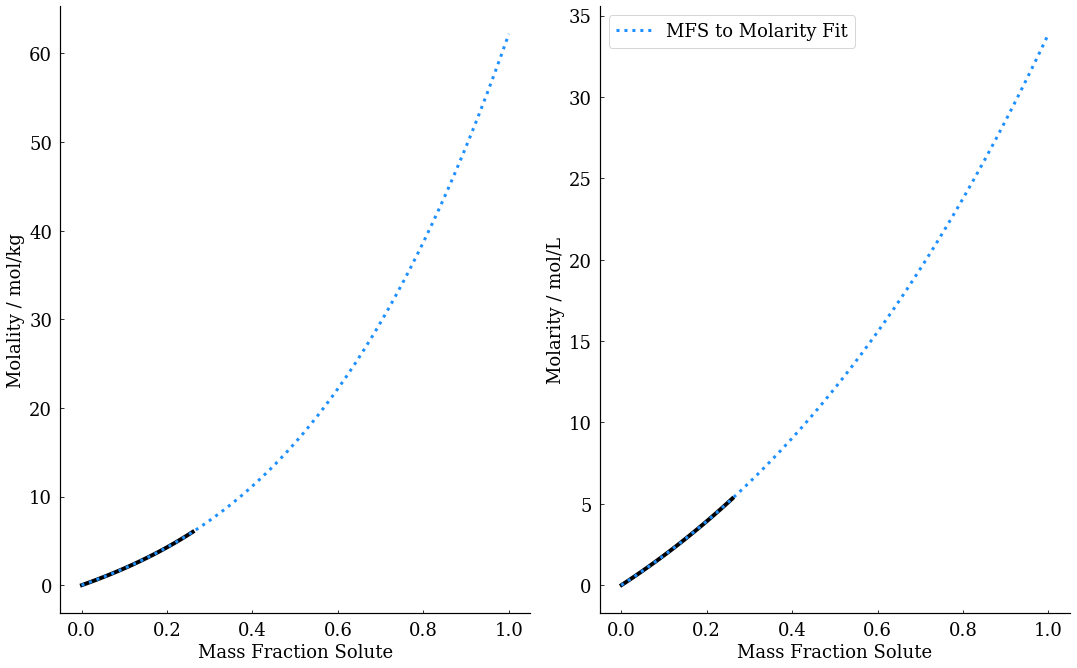

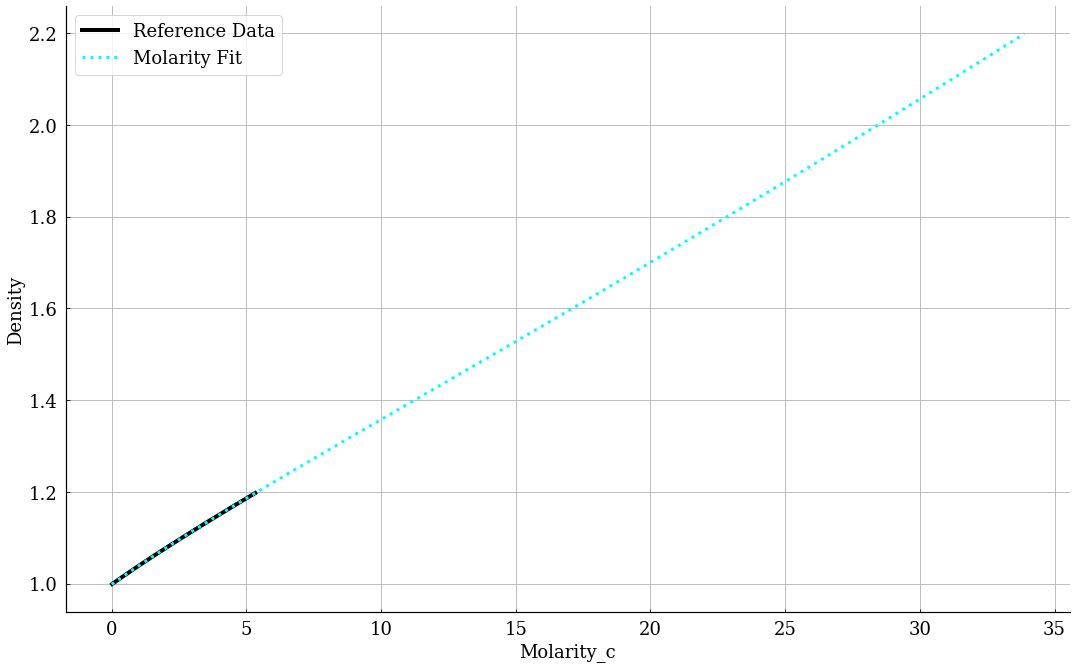

Potassium chloride


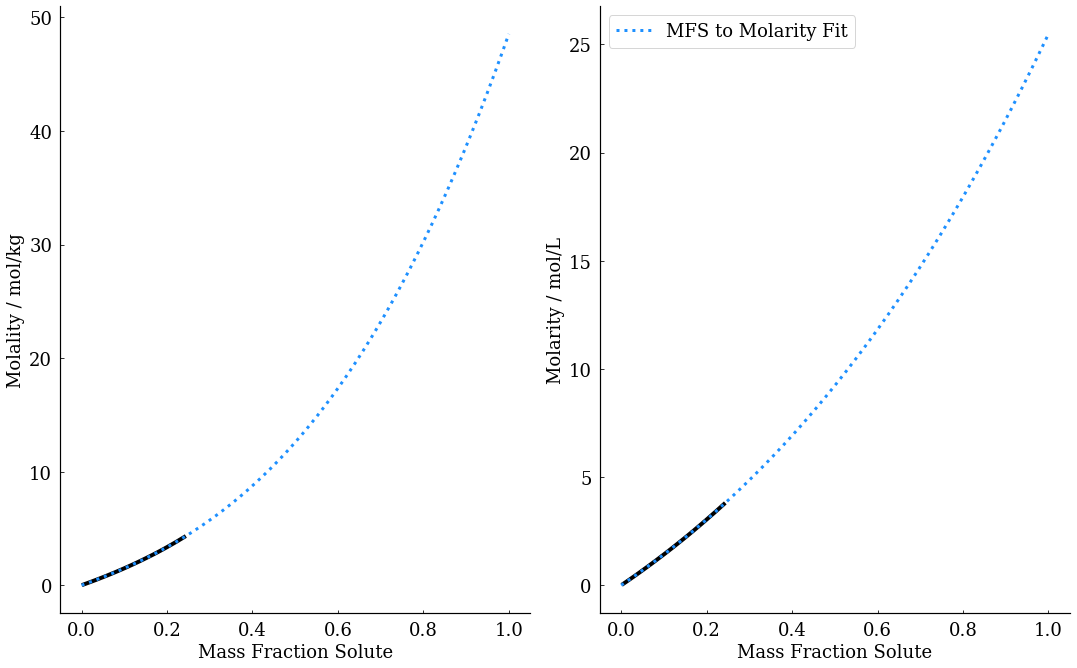

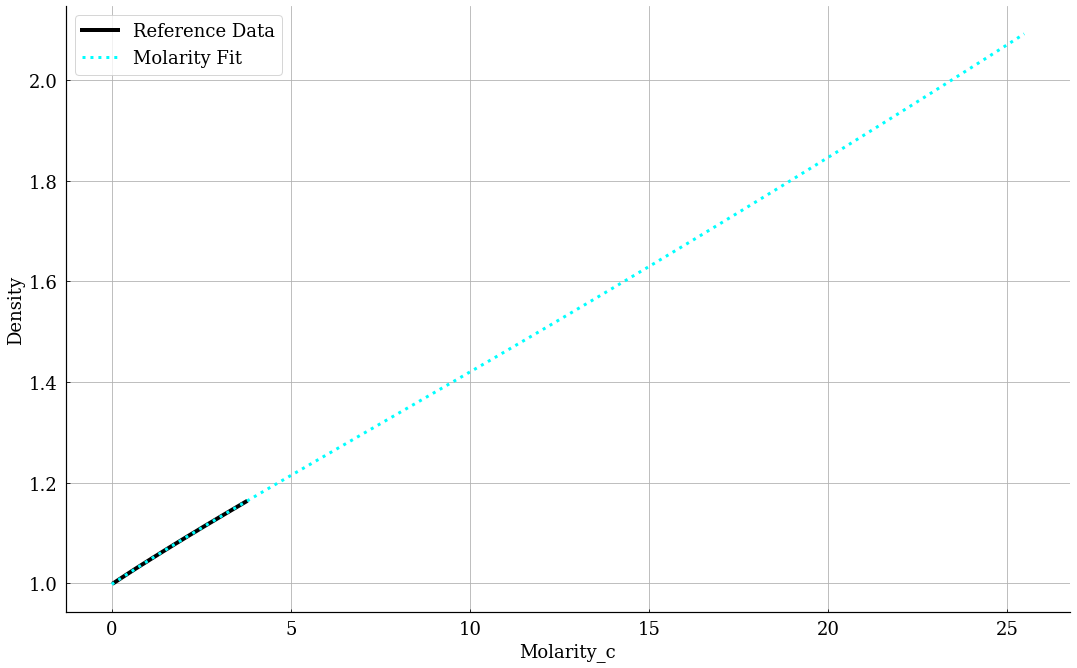

Potassium iodide


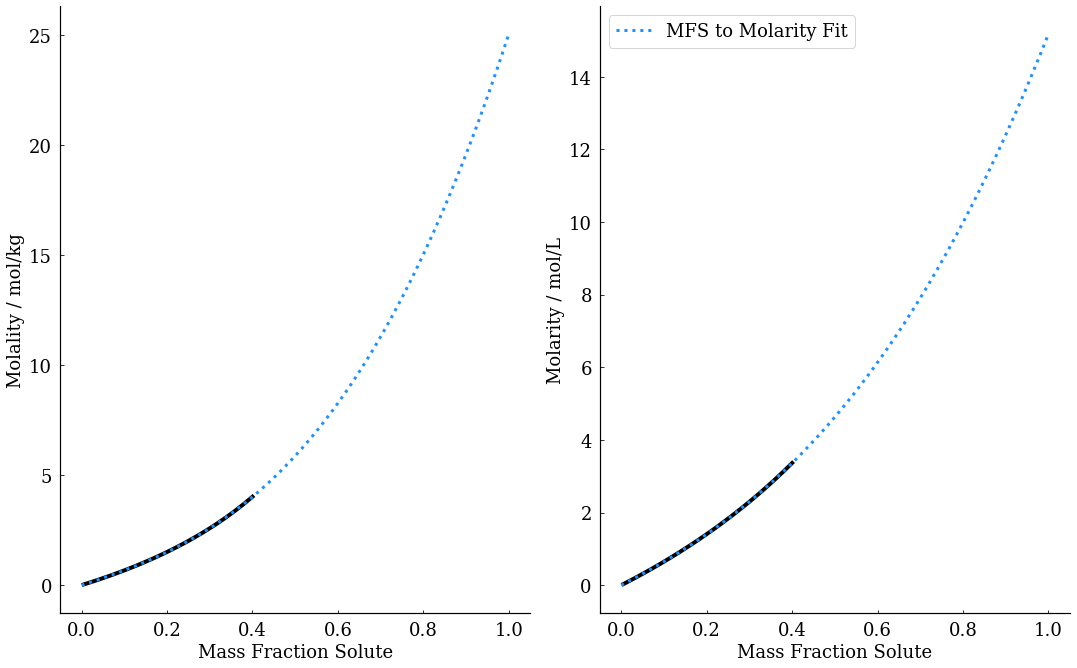

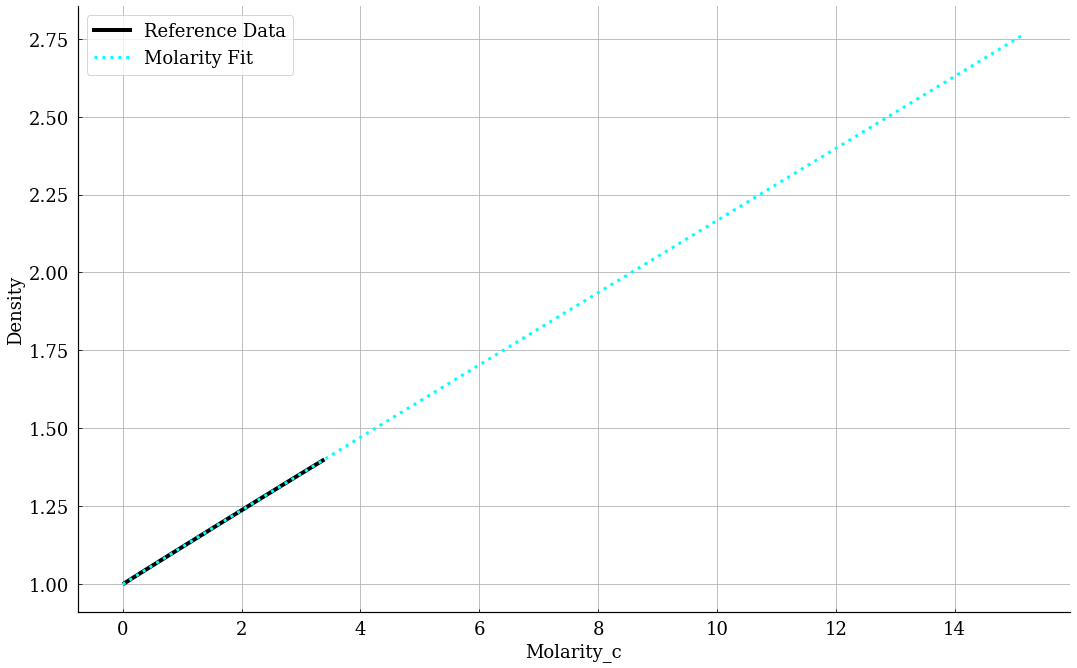

Sodium nitrate


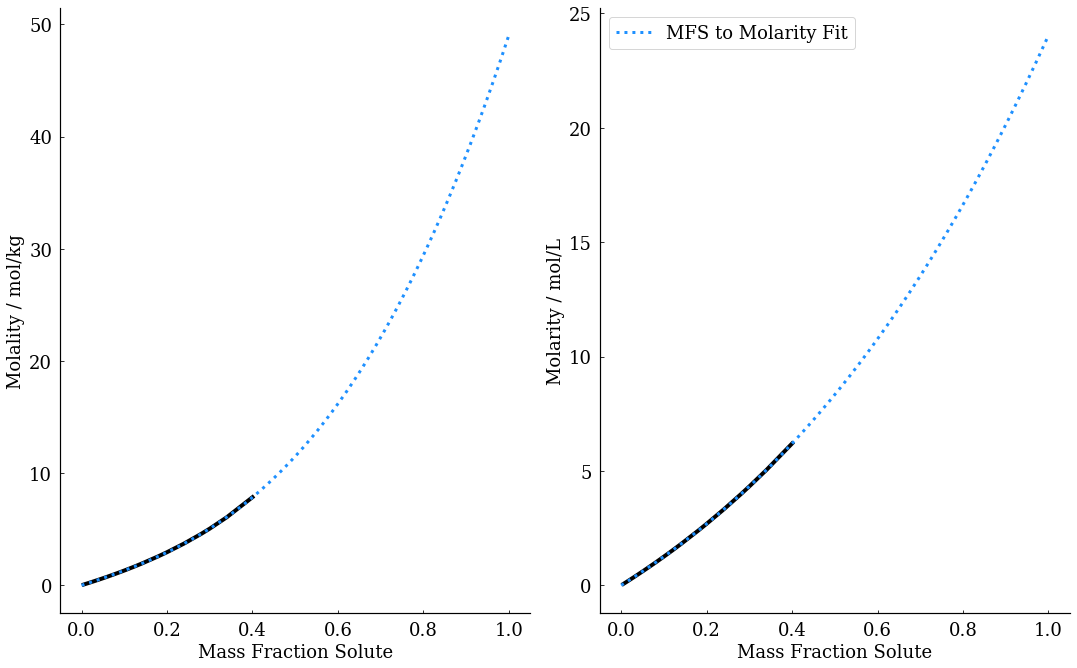

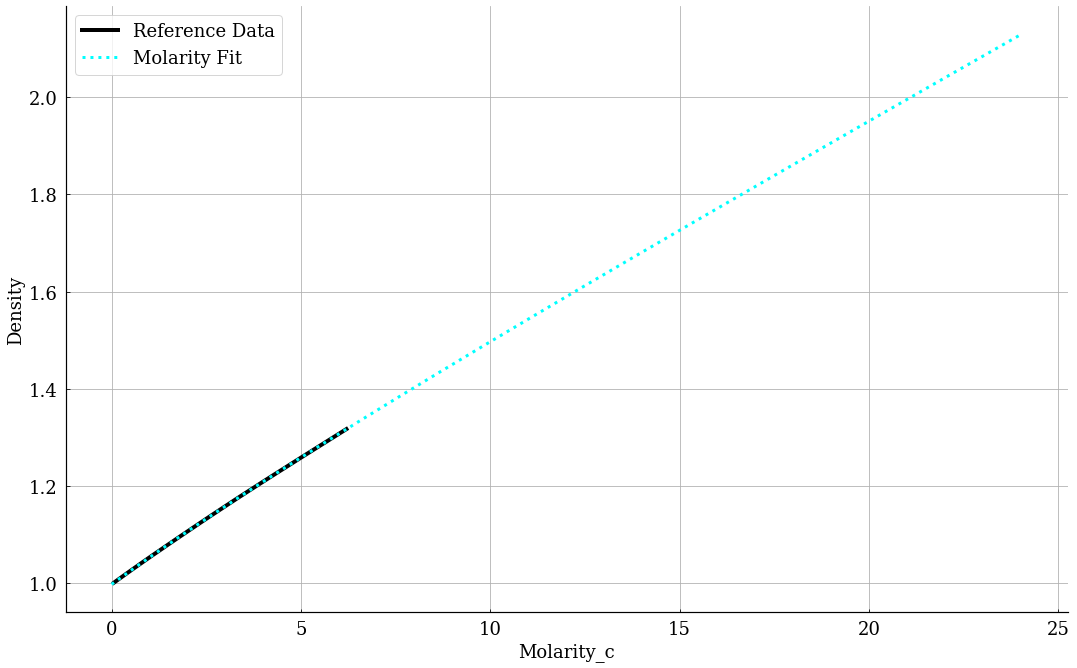

Potassium nitrate


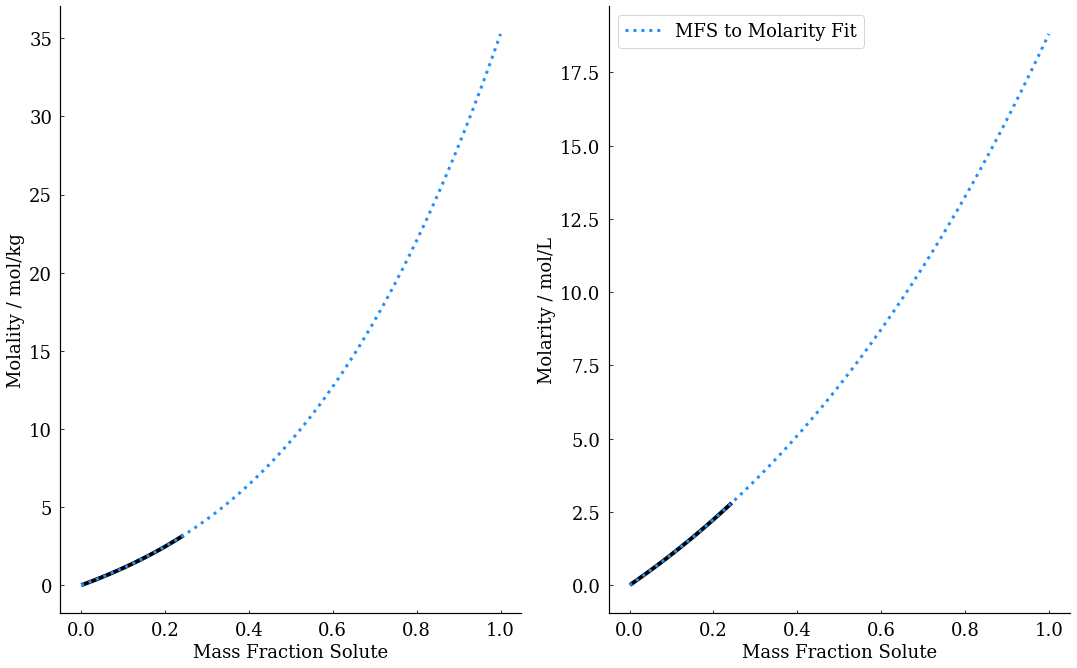

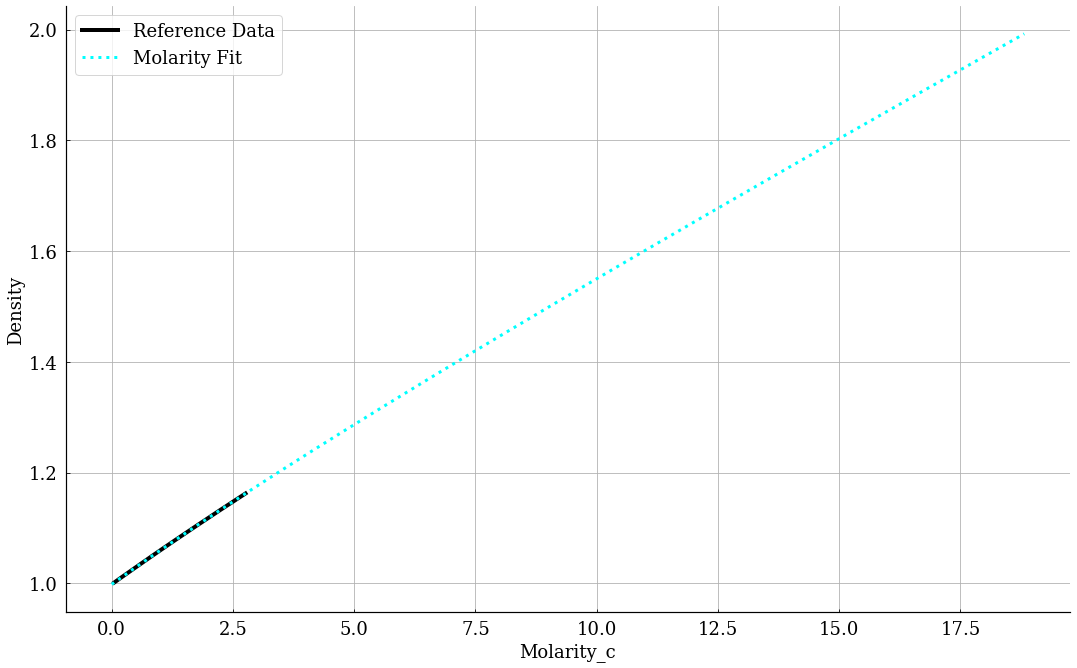

Sodium sulfate


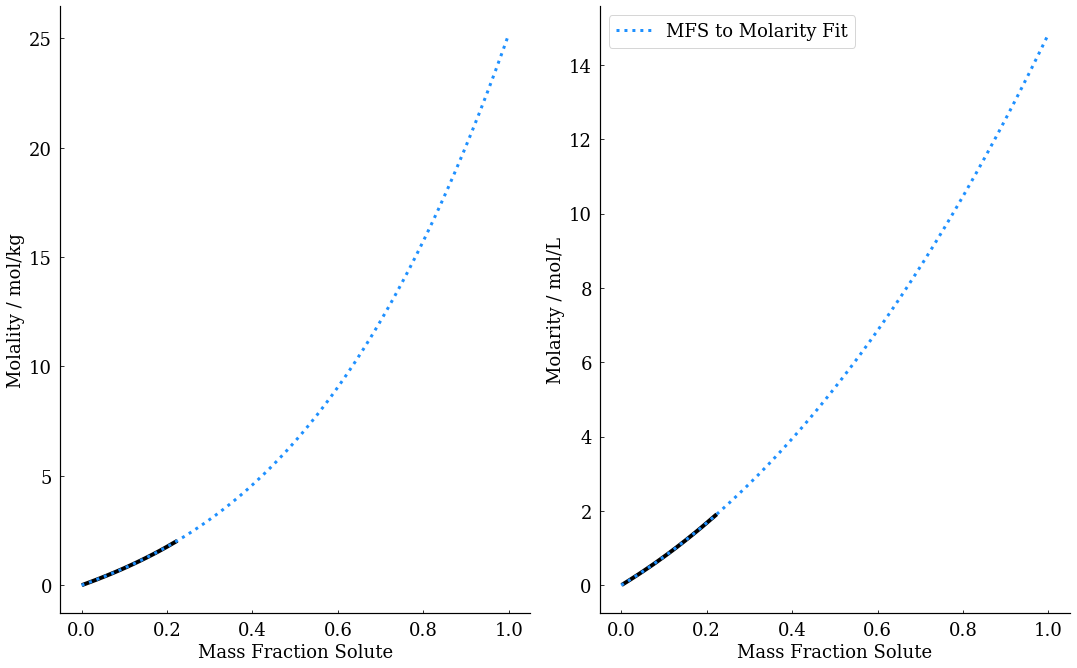

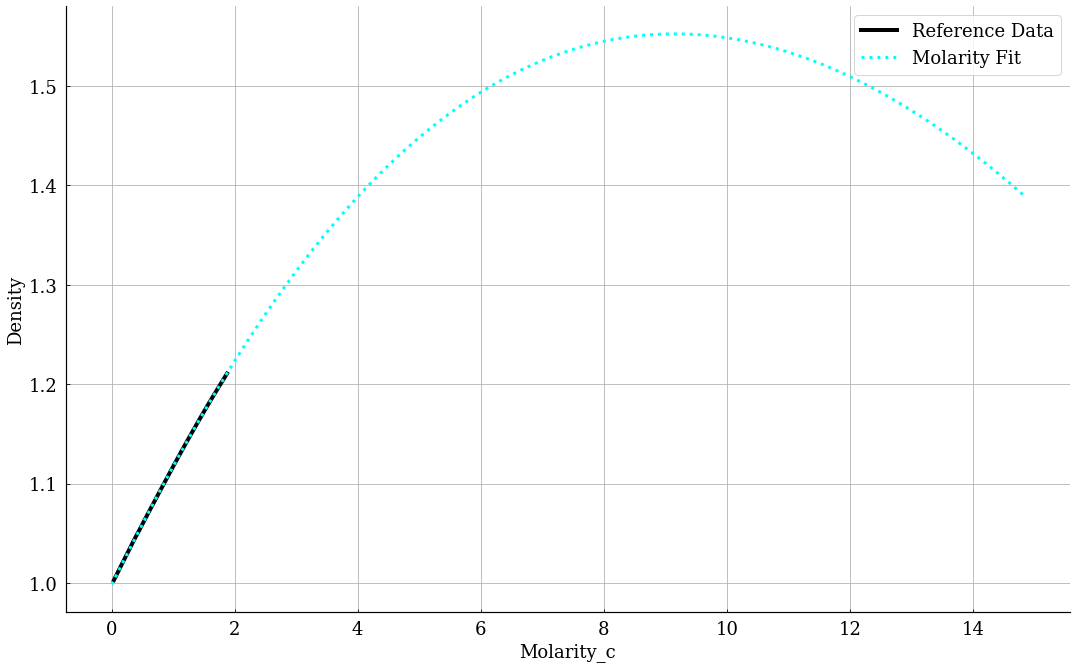

Potassium sulfate


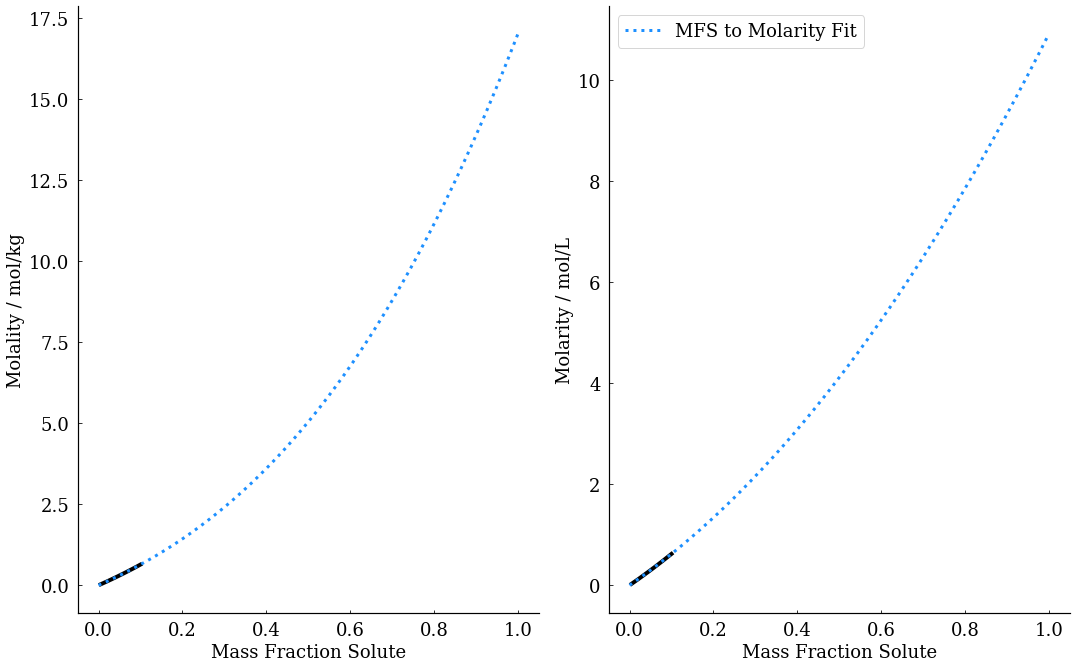

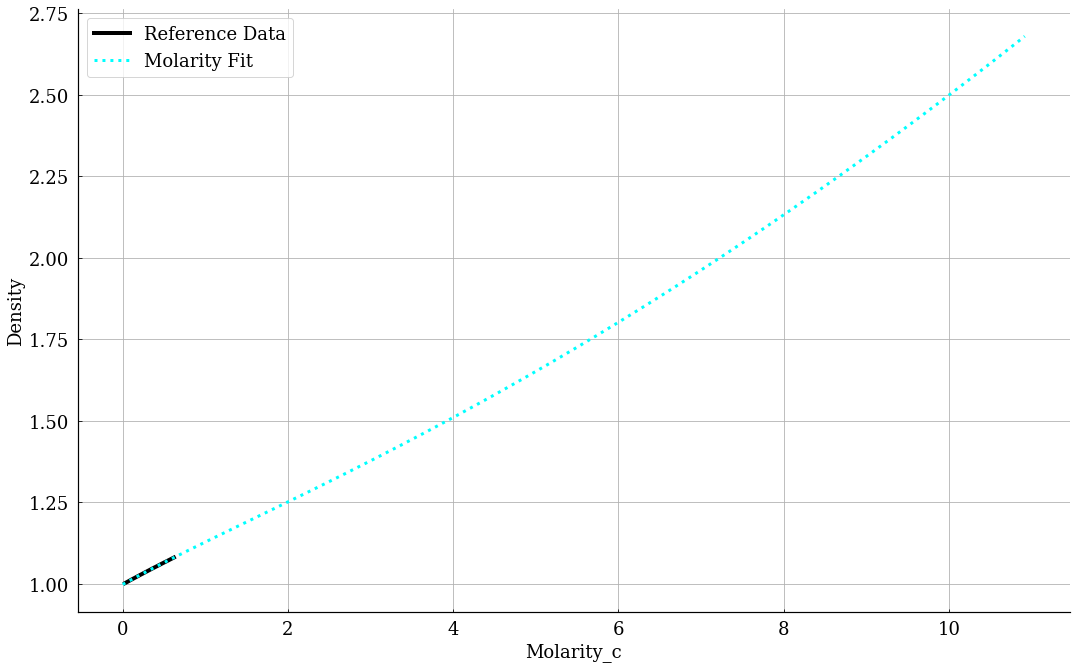

Magnesium sulfate


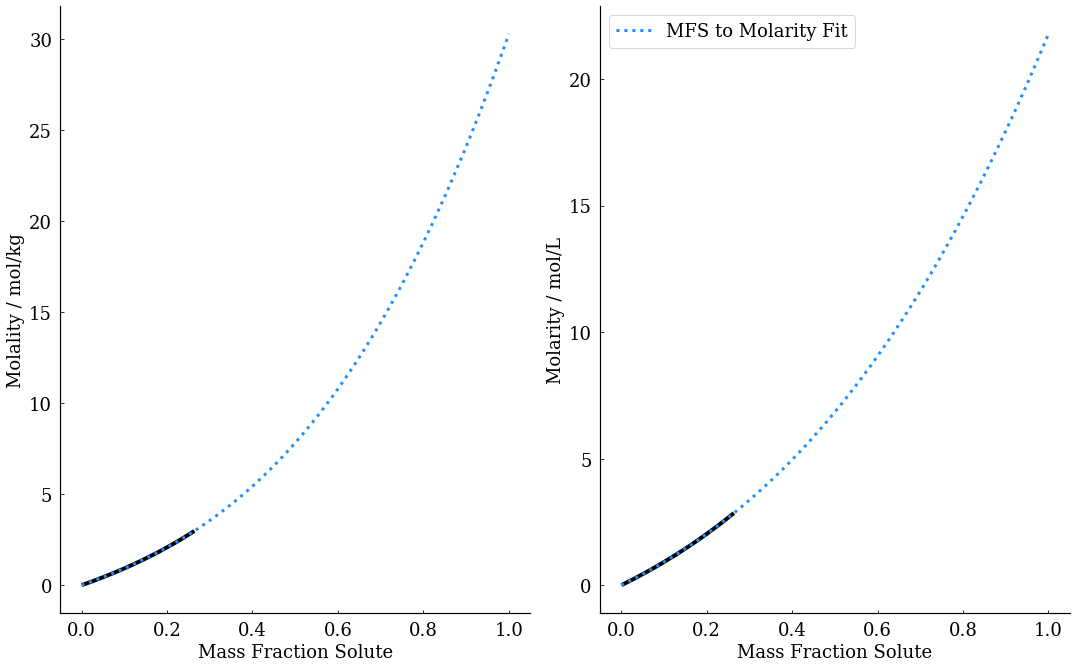

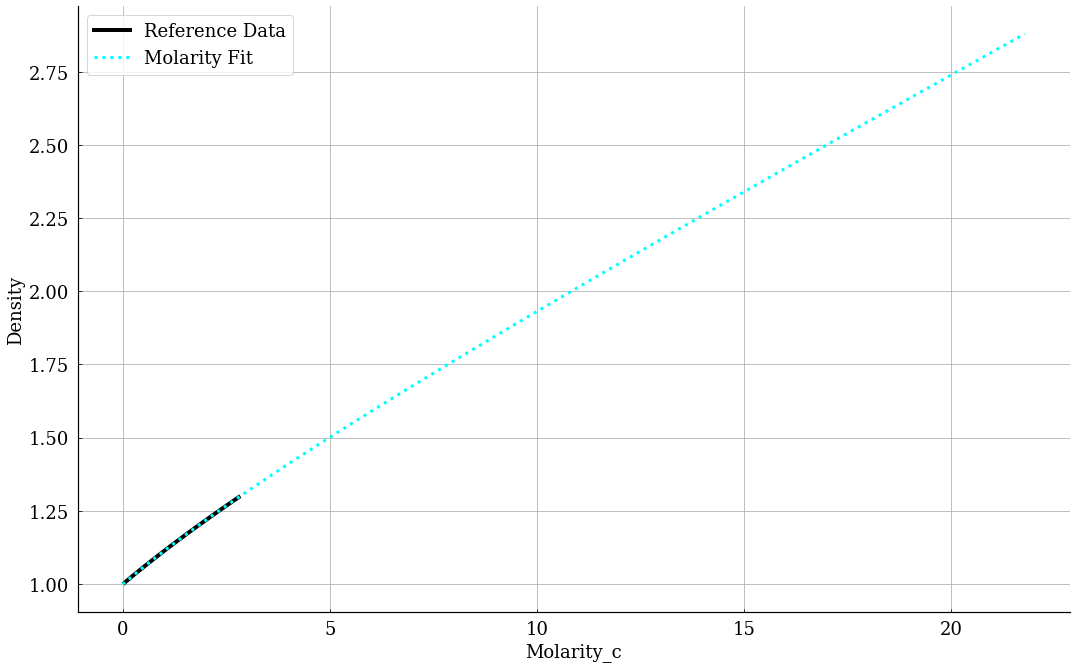

In [14]:
compounds_list = ['Sodium chloride', 'Potassium chloride',
                  'Potassium iodide',
                  'Sodium nitrate', 'Potassium nitrate',
                  'Sodium sulfate', 'Potassium sulfate', 'Magnesium sulfate']

for name in compounds_list:
    print (name)
    show_mol_ratio(name)
    show_poly_fit(name, 'Molarity_c', 'Density')

Sodium chloride 0.8846974978268891
Potassium chloride 0.691175286238269
Potassium iodide 0.3125402401306404
Sodium nitrate 0.6075216504942293
Potassium nitrate 0.5092436230252915
Sodium sulfate 0.36699800454324255
Potassium sulfate 0.2979236380487779
Magnesium sulfate 0.4360452534575216


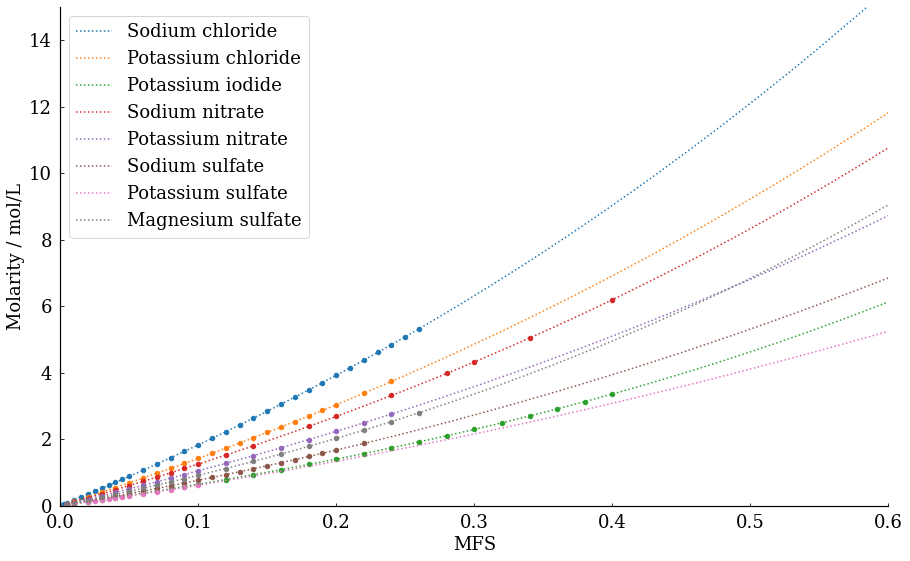

In [35]:
for name in compounds_list:
    plt.plot(mfs_range, solutions['MFS_molar'][solutions['Solute'].index(name)](mfs_range), ':', label = name)
    plt.scatter(solutions['data'][solutions['Solute'].index(name)].Mass_fraction,
                solutions['data'][solutions['Solute'].index(name)].Molarity_c,
                s = 20)
    print(name, solutions['MFS_molar'][solutions['Solute'].index(name)](0.05))
    
plt.xlim(0,0.6)
plt.ylim(0,15)

plt.xlabel('MFS')
plt.ylabel('Molarity / mol/L')
    
plt.legend()
plt.show()

In [20]:
solutions['MFS_molar'][solutions['Solute'].index('Sodium chloride')](0.05)

0.8846974978268891

In [27]:
solutions['MFS_molar'][solutions['Solute'].index('Potassium chloride')](0.0635)

0.8852527992153733